### Plotting alignment data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import csv
import pandas as pd
import utils.db_utils as db
import utils.plot_utils as plot
import utils.file_utils as file

bibleType = 'en_ult'
type_ = 'kt'
dbPath = f'./data/{bibleType}_alignments.sqlite'

connection = db.initAlignmentDB(dbPath)

Connection to SQLite DB successful


In [2]:
# get alignments for tW keyterms

minAlignments = 100
remove = ['ὁ']
alignmentsForWord, filteredAlignmentsForWord = db.fetchAlignmentDataForLemmasCached(connection, type_, bibleType, minAlignments, remove)

Using cached Alignments


In [3]:
# find all alignments for this original word

# word = 'Θεός' # found 69
# word = 'Θεὸς' # found 239
# word = 'Θεοῦ'  # found 712
# origAlignments = getDataFrameForOriginalWords(connection, word, searchLemma = False)
# origAlignments

### Analysis of alignments for keyterms in the en_ult:

#### Frequency of alignments:
_***Note that each line on the graphs below represents an alignment for a specific word. For example we have separate lines for 'Θεός', 'Θεὸς', or 'Θεοῦ' even though they have the same lemma.  It made sense to group the alignments this way since aligners are likely to choose different target language words based on morphology of the word._

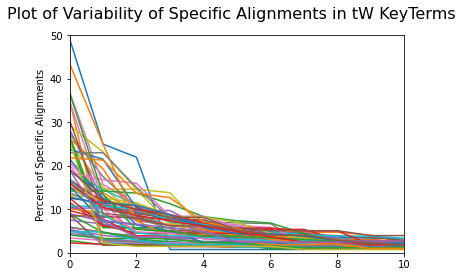

In [4]:
frequenciesOfAlignments = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, 'alignmentTxt')

title = f"Plot of Variability of Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlimit = [0, 10]
plot.plotFrequencies(frequenciesOfAlignments, title, ylabel, showXValues=False, xlimit=xlimit)

### Analysis:

#### Analysis of numerical metrics:

#### Analysis of original language word count:

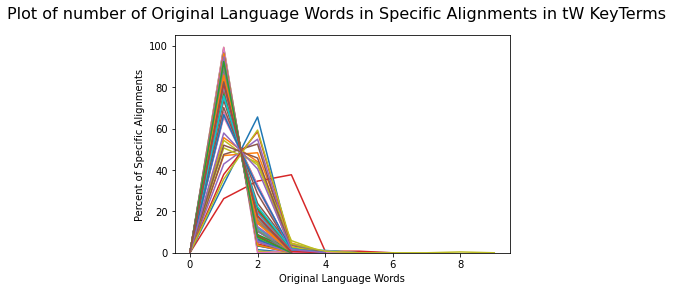

In [5]:
field = 'alignmentOrigWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that original word counts are tight - a threshold word count of 3 probably good for English to flag for review.
<p></p>

#### Analysis of target language word count:

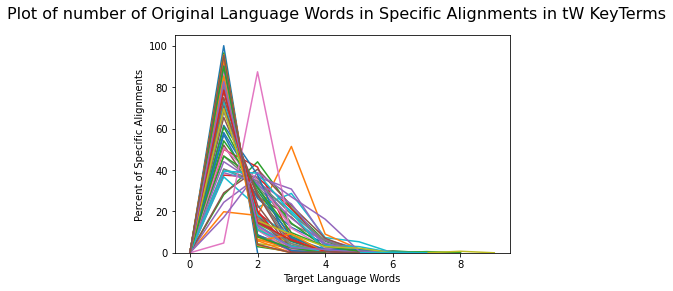

In [6]:
field = 'alignmentTargetWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Target Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that a threshold word count of 3 probably good for English to flag for review.
<p></p>

#### Analysis of count of extra unaligned words between aligned original language words:

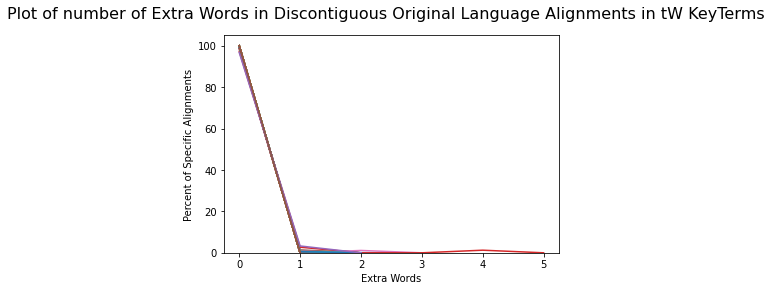

In [7]:
field = 'origWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Original Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that most original language alignments probably good. Probably the cases of a word between aligned words should be reviewed.
<p></p>

#### Analysis of count of extra unaligned words between aligned target language words:

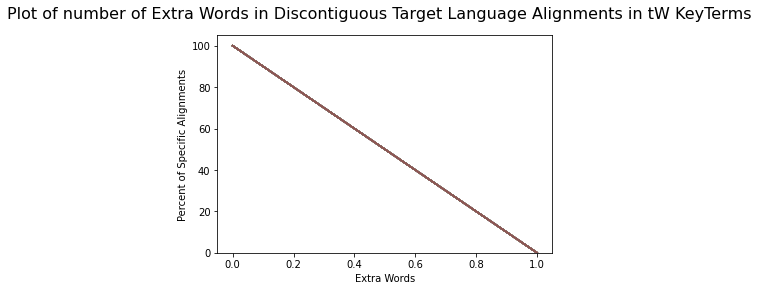

In [8]:
field = 'targetWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Target Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that most target language alignments are very tight.

#### Generate CSV of questionable alignments:

In [9]:
alignmentOrigWordsThreshold = 3
alignmentTargetWordsThreshold = 5
origWordsBetweenThreshold = 1
targetWordsBetweenThreshold = 1
warningData = db.generateWarnings(type_, bibleType, filteredAlignmentsForWord, alignmentOrigWordsThreshold,
                                  alignmentTargetWordsThreshold, origWordsBetweenThreshold, targetWordsBetweenThreshold)
print(f"Found {len(warningData)} alignments to check")

Found 363 alignments to check
